##### Listing 6.1

 概括遗传算法中字符串的进化过程，将一组随机串进化成目标串。我们从随机字符串的总体开始，将每个字符串与目标字符串进行比较，并根据每个字符串与目标字符串的相似程度为其分配匹配度分数。然后选择高匹配性的“父母”交配（或重组）来产生后代，接着对后代进行突变，引入新的遗传变异。重复上述过程，直到下一代种群被填满（与初始人口数量相同）

以下代码创建了一个个体的初始种群，这些个体是由一个字符串和一个匹配分数字段组成的类对象。接下来，通过从一个字母的字符串列表中抽样来创建随机字符串。一旦有了一个群体，我们需要评估每个个体的匹配度。对于字符串，可以使用 Python 内置模块SequenceMatcher 来计算相似度。

In [4]:
#进化字符串：创建随机字符串
import random
import numpy as np
from matplotlib import pyplot as plt

#从中抽样，以产生随机字符串的字符列表
alphabet = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,.! " #定义可用字符包括大小写字母、标点符号和空格
target = "Hello World!"   #试图从一个随机种群中进化出的字符串

#创建一个简单的类来存储种群中每个成员的信息
class Individual: #表示族群的一个个体，包含一个字符串和一个适应度值
    def __init__(self, string, fitness=0):
        self.string = string
        self.fitness = fitness #适应度：评估个体与目标的接近程度
#导入SequenceMatcher用于计算字符串相似程度
from difflib import SequenceMatcher

def similar(a, b): #结算两个字符串之间的相似度比率
    #a和b是要比较的两个字符
    return SequenceMatcher(None, a, b).ratio()
#spawn_population 创建初始种群
def spawn_population(length=26,size=100):   #生成一个初始的字符串随机种群
    pop = []
    for i in range(size):
        #.join 用于将列表中的元素链接成一个字符串
        #'' 表示使用空字符串作为连接符
        string = ''.join(random.choices(alphabet,k=length))
        individual = Individual(string)
        pop.append(individual)
    return pop


##### Listing 6.2

以下代码定义了两个函数 recombine 和 mutate，前者接收两个父字符串并将他们重组来创建两个新的字符串，而后者将随机翻转字符串中的字符以让其产生变异。

突变过程接收一个像“hellb” 这样的字符串，并以较小的概率（突变率）将字符串中的一个字符替代为随机字符。例如，突变过程可能将“hellb”变为“hello”。 突变的目的就是引入新的信息（方差）到种群。如果只进行重组，很可能种群中的所有个体太快变得过于相似，而无法找到想要的解决方案，因为如果没有突变，那么每一代的信息都会产生丢失。

注：突变率很关键。如果突变率太高，那么匹配的个体就会因为突变而失去匹配性；太低就没有足够的方差来找到最优的个体。

In [5]:
#重组函数
def recombine(p1_, p2_): #接收两个父代个体，将两个父字符重组为两个新的字符串
    p1 = p1_.string
    p2 = p2_.string
    child1 = []
    child2 = []
    cross_pt = random.randint(0,len(p1))  #随机选择一个交叉点cross_pt
    child1.extend(p1[0:cross_pt])
    child1.extend(p2[cross_pt:])  #p1 前部分+p2 后部分
    child2.extend(p2[0:cross_pt])
    child2.extend(p1[cross_pt:])  #p2 前部分+p1 后部分
    c1 = Individual(''.join(child1))
    c2 = Individual(''.join(child2))
    return c1, c2


 #变异函数   
def mutate(x, mut_rate=0.01): #接收个体x和变异率mut_rate。通过随机翻转字符来变异字符串
    new_x_ = []
    for char in x.string:
        if random.random() < mut_rate:
            #.extend用于将一个列表中的所有元素添加到另一个列表中。直接修改原始列表，而不是创建一个新的列表。
            new_x_.extend(random.choices(alphabet,k=1))
        else:
            new_x_.append(char)
    new_x = Individual(''.join(new_x_))
    return new_x


##### Listing 6.3

以下代码定义了一个函数，用于遍历字符串种群中的每个个体，为其分配一个匹配度分数，并将他与该个体关联。还定义了一个用于创建后续世代的函数。

In [6]:
#种群评估函数
#给种群中的每个个体分配一个匹配度分数
def evaluate_population(pop, target): #接收一个种群列表 pop 和目标字符串 target
    avg_fit = 0
    for i in range(len(pop)):
        fit = similar(pop[i].string, target)
        pop[i].fitness = fit  #将计算出的相似度赋值给个体的适应度属性
        avg_fit += fit
    avg_fit /= len(pop)
    #返回更新了适应度的种群和平均适应度值
    return pop, avg_fit

#通过重组和突变创建新一代
def next_generation(pop, size=100, length=26, mut_rate=0.01): 
    new_pop = []
    while len(new_pop) < size:
        #使用 random.choices 函数按照适应度权重随机选择两个父代个体
        parents = random.choices(pop,k=2, weights=[x.fitness for x in pop])
        offspring_ = recombine(parents[0],parents[1])
        child1 = mutate(offspring_[0], mut_rate=mut_rate)
        child2 = mutate(offspring_[1], mut_rate=mut_rate)
        offspring = [child1, child2]  #添加变异后的子代到新种群
        new_pop.extend(offspring)
    return new_pop


这是完成进化过程所需要的最后两个函数。其中一个函数评估种群中的每个个体，并为其分配一个匹配度分数-该分数仅表示个体字符串与目标字符串的相似程度，匹配度分数将根据给定问题目标的不同而且发生变化。最后，另一个函数通过抽样当前种群中最匹配的个体，对其进行重新组合来产生后代，并使其发生突变，从而产生一个新种群。

以下代码将所有功能组合在一起，并重复前面的步骤，直至达到最大的世代数，也就是说，从一个初始种群开始，经历个体匹配度评分和创建新的后代种群过程，然后重复这个序列很多次。在足够多世代之后，我们期望最终的种群包含很多非常接近目标字符串的字符串。

##### Listing 6.4

In [7]:
num_generations = 150  #最大迭代次数
population_size = 900  #种群大小
str_len = len(target)  #个体字符串长度，与目标字符串长度相同
mutation_rate = 0.00001 #变异率

pop_fit = []
pop = spawn_population(size=population_size, length=str_len) #创建初始群体
done = False
for gen in range(num_generations):
    pop, avg_fit = evaluate_population(pop, target)
    pop_fit.append(avg_fit) #记录当前平均适应度
    new_pop = next_generation(pop, size=population_size, length=str_len, mut_rate=mutation_rate)
    pop = new_pop
    #检查是否有个体达标
    for x in pop: 
        if x.string == target: 
            print("Target Found!")
            done = True
    #如果找到目标，提前结束循环
    if done:
        break

In [8]:
#按照适应度从高到低排列所有个体
# sort方法默认按升序排序，reverse=True参数将排序顺序反转，变成降序
pop.sort(key=lambda x: x.fitness, reverse=True) 
pop[0].string

'lHello Wrld!'

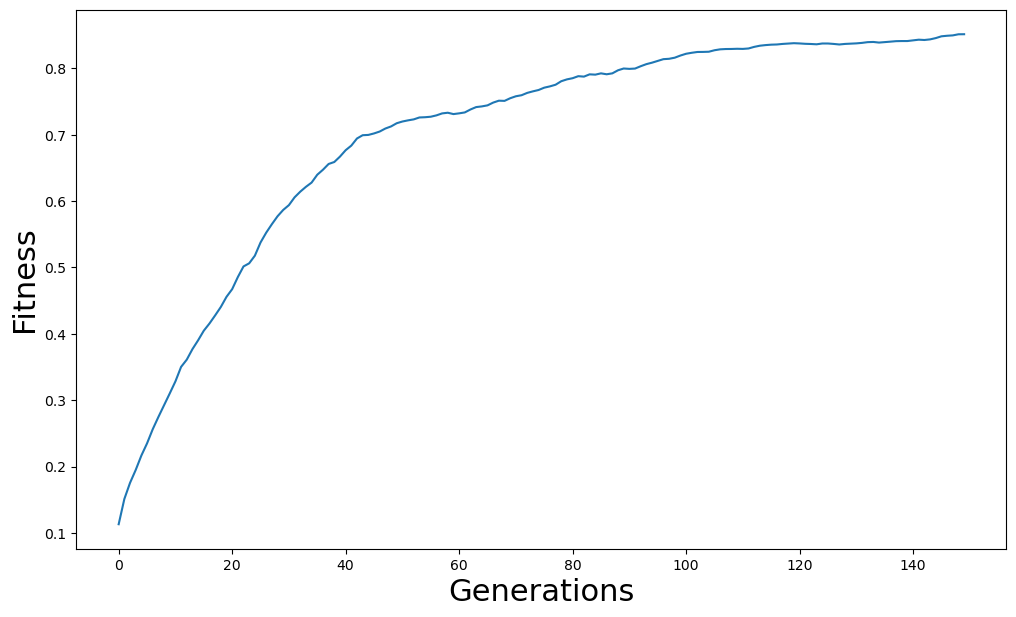

In [9]:
plt.figure(figsize=(12,7))
plt.xlabel("Generations",fontsize=22)
plt.ylabel("Fitness",fontsize=22)
plt.plot(pop_fit)

种群的平均匹配度随世代数的变化。种群的平均匹配度单调递增然后趋于平稳，看起来很有希望。如果图形非常参差不齐，那么说明突变率可能太高或者种群规模太小。如果图形收敛的太快，说明突变率可能太低

##### Listing 6.5  CartPole的遗传算法
CartPole Example

In [10]:
import torch

Total number of parameters: $4*25 + 25 + 10*25 + 10 + 2*10 + 2 = 407$

定义一个 3 层的神经网络。其中前两层使用 relu 激活函数，最后一层使用 log_softmax 激活函数，这样得到的最终输出就是动作的对数概率。

注：该函数需要一个输入状态 x 和unpacked_params，其中unpacked_params 是每层中使用的单独参数矩阵的元组


## 定义一个智能体

In [11]:
#接收两个参数：输入数据x和解包后的模型参数unpacked_params。
def model(x,unpacked_params):
    #将传入的参数元组解包为三层网络的权重和偏置
    l1,b1,l2,b2,l3,b3 = unpacked_params   #将参数向量解包到单层矩阵中
    y = torch.nn.functional.linear(x,l1,b1) #一个简单的带有偏置的线性层
    y = torch.relu(y) #一个relu 激活函数
    y = torch.nn.functional.linear(y,l2,b2)
    y = torch.relu(y)
    y = torch.nn.functional.linear(y,l3,b3)
    #使用softmax激活函数，通常用于分类问题
    y = torch.log_softmax(y,dim=0)   #最后一层将输出动作的对数概率
    return y


##### Listing 6.6

### 解包参数向量

为了使重组和突变过程变得更容易，我们将创建一对参数向量，然后将其解包或分解成单个参数矩阵，以用于神经网络的每一层。

函数接收一个扁平的参数向量作为 params 输入，以及一个网络层规格（一个元组列表）作为 layers 输入，他将参数向量解包为一组单独的层矩阵和偏差向量，并存储在一个列表中。layers 的默认设置指定了一个 3 层神经网络，由三个分别为 25*4、10*25、2*10 的权重矩阵以及三个分别为 1*25、1*10 和 1*2 的偏差向量组成，因此扁平的参数向量中一共有25*4+25+10*25+10+2*10+2=407 个参数。 

增加使用扁平参数向量并解包使用他们的复杂性，唯一原因是希望能够改变和重组整改参数集，这最终会变得更简单，并与我们对字符串所做的操作相匹配。另一种方法是将每一层的神经网络当作一个单独的染色体，只有匹配的染色体才会重组。利用这种方法，神经网络只会重组相同层的参数，可以防止后面网络层的信息破坏前面网络层的信息。

In [12]:
#这个函数用于将一维参数向量解包成神经网络的权重和偏置矩阵，是进化算法优化神经网络的关键组件。
#params：一维参数向量
#layers：网络层结构列表，默认为三层网络，每个元组表示（输出维度，输入维度）
def unpack_params(params, layers=[(25,4),(10,25),(2,10)]): #layers参数指定每个层矩阵的形状
    unpacked_params = [] #创建空列表存储解包后的参数
    e = 0  #初始化结束索引e为0
    #i 是当前层的索引，l 是当前层的结构元组 (输出维度, 输入维度)
    for i,l in enumerate(layers): #遍历每一层的结构
        #np.prod(l) 用于计算元组 l 中两个元素的乘积，也就是当前层权重矩阵的元素个数。
        s,e = e,e+np.prod(l)  #计算权重矩阵的起始索引 s 和结束索引 e
        weights = params[s:e].view(l) #将每个层解包为矩阵形式
        s,e = e,e+l[0]
        bias = params[s:e]
        unpacked_params.extend([weights,bias]) #将解包的张量添加到列表中
    return unpacked_params


##### Listing 6.7

创建一个种群

每个智能体都是一个简单的 Python 字典，其中存储着该智能体的参数向量和适应性分数。

In [13]:

def spawn_population(N=50,size=407): #N 为种群中的个体数，size是参数向量的长度
    pop = []
    for i in range(N):
        #torch.randn(size) 生成服从标准正态分布的随机张量，除以2.0是为了缩小初始参数的范围，有助于优化过程的稳定性
        vec = torch.randn(size) / 2.0 #创建一个随机初始化的参数向量
        #初始化适应度为0，并创建一个字典存储参数向量和适应度。
        fit = 0
        p = {'params':vec, 'fitness':fit} #创建一个字典，存储参数向量及其关联的适应性分数
        pop.append(p) #将个体添加到种群列表中，最后返回完整的种群
    return pop

##### Listing 6.8

重组两个父智能体，以产生两个新的子智能体

 这个函数接收两个智能体作为父母，并生成两个后代。通过生成一个随机的分割或交叉点，然后取父智能体 1 的第一段并将其与父智能体 2 的第二段进行组合，同样的将父智能体 1 的第二段与父智能体 2 的第一段进行组合，以此来实现重组功能

In [14]:
def recombine(x1,x2): #x1,x2 是两个字典，表示智能体
    x1 = x1['params'] #只提取参数向量
    x2 = x2['params']
    l = x1.shape[0]
    split_pt = np.random.randint(l) #随机产生一个分割或交叉点
    child1 = torch.zeros(l) #创建两个全零的张量，长度与父代参数向量相同，作为子代参数向量的容器
    child2 = torch.zeros(l)
    child1[0:split_pt] = x1[0:split_pt] #第一个子智能体通过使用父智能体 1 第一段和父智能体 2 的第二段产生
    child1[split_pt:] = x2[split_pt:]
    child2[0:split_pt] = x2[0:split_pt]
    child2[split_pt:] = x1[split_pt:]
    c1 = {'params':child1, 'fitness': 0.0} #将新的参数向量打包进字典，以创建新的子智能体
    c2 = {'params':child2, 'fitness': 0.0}
    return c1, c2


##### Listing 6.9

以较低的概率使个体发生突变。突变是每一代中新的遗传信息的唯一来源--重组只是对已经存在的信息进行重新洗牌

基本上遵循了和字符串例子中相同的流程，随机改变参数向量中的一些元素。突变率用于控制发生突变元素的数量。我们需要小心控制突变率的大小，以平衡新信息的创建和旧信息的破坏，其中新信息可用于改进现有的解决方案。

In [15]:
def mutate(x, rate=0.01): #rate是突变率，其中0.01表示1%的突变率
    x_ = x['params']  #从个体字典中提取参数向量
    num_to_change = int(rate * x_.shape[0]) #根据突变率决定参数向量中有多少元素发生突变
    idx = np.random.randint(low=0,high=x_.shape[0],size=(num_to_change,))  #随机选择变异位置
    x_[idx] = torch.randn(num_to_change) / 10.0 #随机重置参数向量中选定的元素
    x['params'] = x_
    return x

##### Listing 6.10

In [16]:
import gymnasium as gym
env = gym.make("CartPole-v1")

### 在环境中测试每个智能体

test_model函数接收一个智能体（参数向量及其适应度值的一个字典），将其运行于CartPole环境中直到输掉游戏，然后将其持续的时间步数量作为分数返回。我们目的是训练在CartPole中持续的时间步数数量越来越多的智能体（因此获得高分）

In [17]:
#函数接收一个参数agent，这是一个包含神经网络参数的字典
def test_model(agent):
    done = False
    s = env.reset()[0]
    #将初始状态从 NumPy 数组转换为 PyTorch 张量
    state = torch.from_numpy(s).float()
    score = 0
    while not done: #游戏未结束期间
        params = unpack_params(agent['params'])
        probs = model(state,params) #使用智能体的参数向量从模型中获取动作概率
        #创建一个基于概率分布的分类分布（Categorical），从这个分布中采样一个动作
        #torch.distributions.Categorical 是 PyTorch 中用于创建分类分布对象的类。其构造函数接收一个参数 probs
        #probs 是一个一维的 torch.Tensor，表示每个类别的概率。所有概率值之和应该为 1，且每个概率值都应该在 0 到 1 之间
        action = torch.distributions.Categorical(probs=probs).sample() #通过从分类分布中抽样来概率性的选择一个动作
        #action.item：将 action转换为 Python 标量（如 int 或 float）。
        #env.step(action)：让智能体在环境中执行一个动作（action），并返回执行后的结果。
        state_, reward, done, _, info = env.step(action.item())
        state = torch.from_numpy(state_).float()
        score += 1 #记录游戏未结束情况下持续的时间步数量，以此作为分数
    return score


##### Listing 6.11

evaluate_population 函数用于遍历种群中的每个智能体，并使用test_model 函数，以评估他们的适应性。

#### 对种群中的每个智能体进行评估操作

In [ ]:
def evaluate_population(pop):
    tot_fit = 0 #改种群的总体适应度，用于稍后计算种群的平均
    lp = len(pop)
    for agent in pop: #遍历种群中的每个智能体
        score = test_model(agent) #在环境中运行智能体，以评估其适应性
        agent['fitness'] = score #存储适应度值。将得分存储在智能体字典的 'fitness' 键中
        tot_fit += score
    avg_fit = tot_fit / lp  #计算平均适应度
    return pop, avg_fit


##### Listing 6.12

采用随机选择机制。随机选择机制类似于在策略梯度法中选择动作的机制，在那里他能够很好的工作，但在遗传算法中选择父母时，往往导致收敛过快。遗传算法比基于梯度下降的算法需要更多的探索。在本例中，我们将使用一种名为联赛选择的选择机制。

在联赛选择中，从整个种群中选择一个随机子集，然后在该子集中选择前两个个体作为父母，这样就确保了不会总是选择相同的前两个父母，但最终结果是确实更频繁的选择了表现更好的智能体

我们可以改变联赛规模（随机子集的大小），控制我们倾向于在当前世代在选择最好的智能体的程度，但这样做也冒着失去遗传多样性的风险。在极端情况下，我们可以将联赛规模设置的于种群规模相等，此时将只会选择种群中的前两个个体。在另一种极端情况下，我们可以将联赛规模设置为 2，这样就会随机选择父母。

在联赛选择中，我们像往常一样评估种群中所有个体的适应性，接着选择整个种群的一个随机子集，然后选择子集中的前几个个体，将他们交配产生后代并进行突变。重复上述过程，直到填满下一代。

In [ ]:
#创建新种群
#mut_rate：变异率，默认值为 0.001，即 0.1% 的概率对个体进行变异操作
#pop：当前种群，是一个包含多个个体的列表，每个个体通常是一个字典，至少包含 'fitness' 键表示该个体的适应度分数。
#tournament_size：锦标赛选择的子集大小比例，默认值为 0.2，表示从种群中随机选取 20% 的个体进行锦标赛选择。
def next_generation(pop,mut_rate=0.001,tournament_size=0.2):
    new_pop = []
    lp = len(pop)
    while len(new_pop) < len(pop): #新种群没满时
        rids = np.random.randint(low=0,high=lp,size=(int(tournament_size*lp))) #新种群没满时
        #选择种群的随机子集以获得一批智能体，并将每个智能体与其在原始种群中的索引值进行匹配
        #enumerate 是Python内置的函数，它会对可迭代对象（这里是 pop 列表）进行遍历，同时返回元素的索引和元素本身。
        #使用列表推导式遍历当前种群 pop，对于索引 i 在 rids 中的个体，将其索引 i 和适应度分数 x['fitness'] 组成一个列表 [i, x['fitness']]，最后将这些列表转换为一个二维的 numpy 数组 batch
        batch = np.array([[i,x['fitness']] for (i,x) in enumerate(pop) if i in rids]) 
        scores = batch[batch[:, 1].argsort()] #按分数递增顺序排列这批智能体
        #排在最后一个的就是分数最高的智能体，选择分数最高的前两个智能体作为父母
        #scores[-1][0] 和 scores[-2][0]：分别表示排序后 scores 数组中最后一行和倒数第二行的第一列元素，即适应度最高和次高的个体在原始种群中的索引。
        i0, i1 = int(scores[-1][0]),int(scores[-2][0]) 
        #pop[i0] 和 pop[i1]：根据索引从原始种群中取出适应度最高和次高的个体作为父母。
        parent0,parent1 = pop[i0],pop[i1]
        offspring_ = recombine(parent0,parent1) #重组父母以得到后代
        child1 = mutate(offspring_[0], rate=mut_rate) #在将后代放入新种群之前先让他们突变
        child2 = mutate(offspring_[1], rate=mut_rate)
        offspring = [child1, child2]
        new_pop.extend(offspring)
    return new_pop


next_generation创建了一个随机索引的列表，用于检索种群列表，并未联赛批次创建了一个子集。我们使用 enumerate 函数记录子集中的每个智能体的索引位置，这样就可以在主种群中引用他们，然后按升序对这批适应性分数进行排练，并将列表中的最后两个元素作为该批中的前两个个体，最后查找他们的索引，并从原始种群列表中选择完整的智能体。

##### Listing 6.13

#### 训练模型

应对突变率、种群规模和世代数等超参数进行实验

第一代从一个随机参数向量的群体开始，但由于偶然性，其中一些个体会比其他的更好，我们会优先选择这些个体进行交配来产生下一代。为了维持遗传多样性，我们允许每个个体进行轻微的变异。这个过程会不断重复，直至得到特别擅长玩CartPole游戏的个体。

In [ ]:
num_generations = 20 #要进行的世代数
population_size = 500 #每一代中个体的数量
mutation_rate = 0.01
pop_fit = []
pop = spawn_population(N=population_size,size=407) #初始化一个种群
for i in range(num_generations):
    pop, avg_fit = evaluate_population(pop) #评估种群中每个智能体的适应度
    pop_fit.append(avg_fit)
    pop = next_generation(pop, mut_rate=mutation_rate,tournament_size=0.2) #构造新种群
    

In [ ]:
def running_mean(x,n=5):
    conv = np.ones(n)
    y = np.zeros(x.shape[0]-n)
    for i in range(x.shape[0]-n):
        #将当前滑动窗口内元素的总和除以窗口大小n，得到该窗口内元素的平均值，并将其赋值给结果数组y的第i个元素
        #@ 运算符是向量点积运算
        y[i] = (conv @ x[i:i+n]) / n
    return y

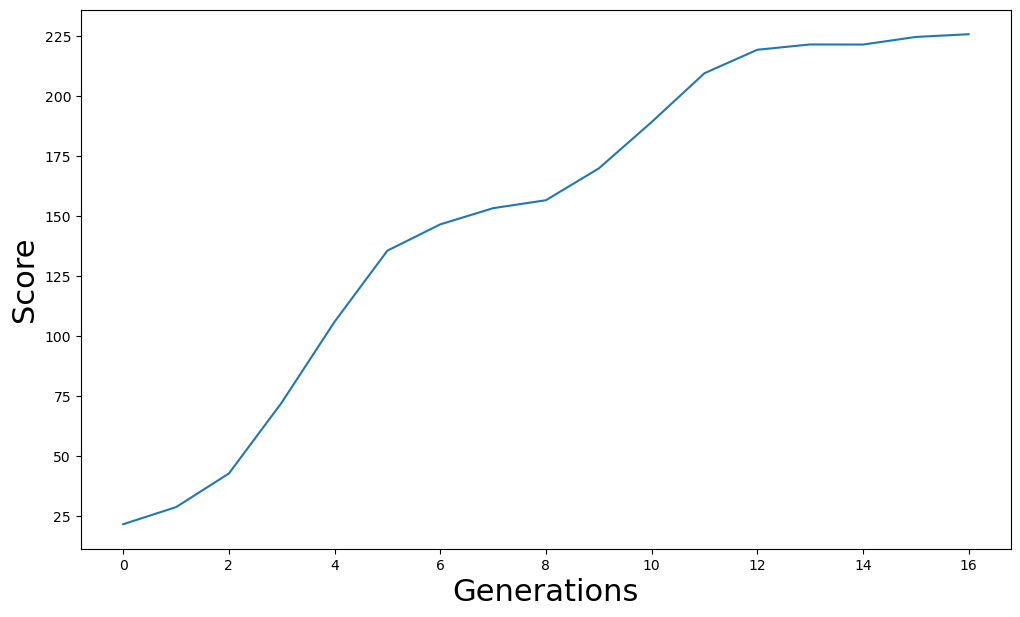

In [ ]:
plt.figure(figsize=(12,7))
plt.xlabel("Generations",fontsize=22)
plt.ylabel("Score",fontsize=22)
plt.plot(running_mean(np.array(pop_fit),3))   #窗口大小为3

In [23]:
test_model(pop[0])

325

/var/folders/wt/t4q1f61n40x0vm0746z9p1hh0000gn/T/ipykernel_18763/966111900.py:7: RuntimeWarning: divide by zero encountered in log
  y = np.log(x)


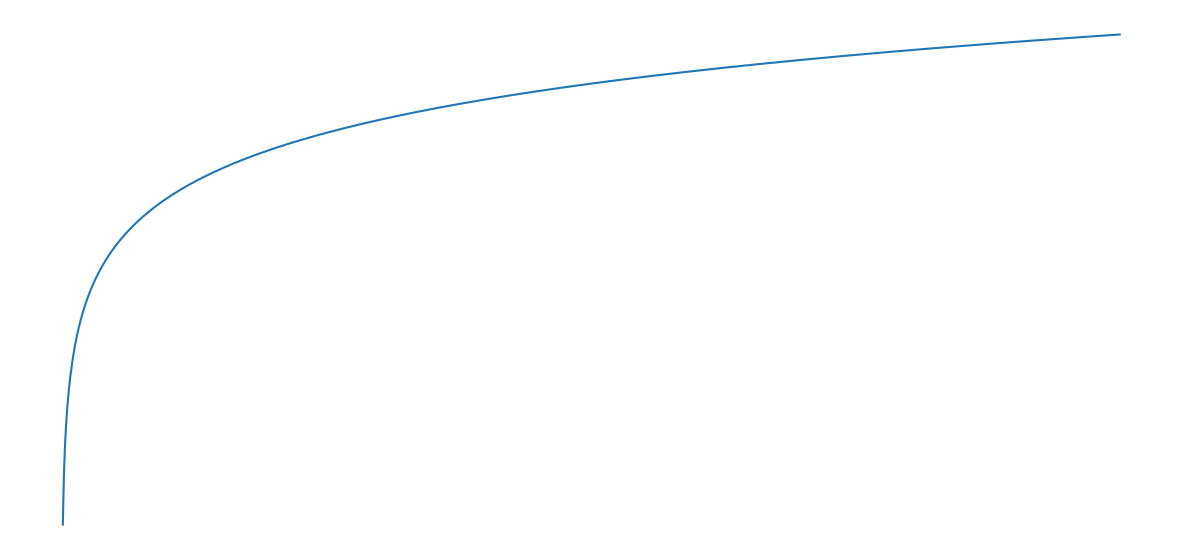

In [ ]:
plt.figure(figsize=(15,7))
#plt.axis('off') 用于隐藏图形的坐标轴，包括坐标轴的刻度、标签和边框
plt.axis('off')
plt.xlabel("Compute resources",fontsize=22)
plt.ylabel("Performance",fontsize=22)
x = np.linspace(0,100,1000)
y = np.log(x)
#plt.plot() 是 matplotlib.pyplot 模块中的函数，用于绘制曲线。
plt.plot(x,y)

无梯度算法的一个优势是，他们会比基于梯度的算法探索的更多。

DQN和策略梯度都遵循相似的策略：收集经验并推动智能体采取导致更大奖励的动作。

进化算法往往比基于梯度的算法更需要样本，因为我们没有策略性的调整智能体的权重，而只是创建了大量的智能体，并希望引入的随机突变和重组是有益的。我们认为进化算法的效率是低于DQN或PG方法。

进化策略：在进化策略中，通过反复想父代个体添加少量随机噪声来产生父代的多个变体，从而创建出一个个体种群。然后，通过在环境中评估来向每个变体分配适应性分数，接着计算所有变体的加权和得到一个新的父体。



确定智能体的适应性通常是训练循环中运行时间最长的任务，他需要在整个环境中运行智能体（可能很多次）。如果在单台计算机上执行此操作，那么将以串行方式执行，此时必须等待一个智能体在环境中运行完成之后，才能开始确定第二个智能体的适应性。运行该算法所花费的时间是智能体数量和单个智能体在整个环境中运行所花费时间的函数。

如果有多台机器可供使用，就可以并行确定每个智能体在各自机器上的适应性。在开始评估下一个智能体之前，不必等当前智能体完成在整个环境中的运行。如果训练智能体的轮次长度很长，那么这样做能够带来巨大的速度提升。现在可以看到，该算法只是评估单个智能体适应性所需时间的函数，而不是所评估智能体数量的函数。

分布式计算的工作原理：主节点将任务分配给工作节点，由工作节点执行这些任务，然后将结果发送回主节点。

进化算法可以优化不可微的甚至离散的函数，而基于梯度的算法则无法做到

进化策略是进化算法的一个子类，不涉及类似生物的交配和重组，而是使用带有噪声和加权的副本来从一个种群创建新的个体